In [1]:
import argparse
import os
import pickle
import shutil
import warnings
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import mmcv
import numpy as np
import torch
from depth.apis import multi_gpu_test, single_gpu_test
from depth.datasets import build_dataloader, build_dataset
from depth.datasets.pipelines import Compose
from depth.models import build_depther
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmcv.runner import get_dist_info, init_dist, load_checkpoint, wrap_fp16_model
from mmcv.utils import DictAction
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
print(device)

%reload_ext autoreload
%autoreload 2


cuda


In [2]:
torch.cuda.set_per_process_memory_fraction(0.1, 0)
torch.cuda.empty_cache()
total_memory = torch.cuda.get_device_properties(0).total_memory
total_memory


15686828032

In [2]:
path_to_images = Path("dataset/block-insertion-test/color/000000-1.pkl")
path_to_config = Path(
    "Monocular-Depth-Estimation-Toolbox/configs/binsformer/binsformer_swint_w7_nyu.py"
)
path_to_checkpoint = Path("checkpoints/binsformer_swint_nyu_converted.pth")
depth_images = pickle.load(
    open(Path("dataset/block-insertion-test/depth/000000-1.pkl"), "rb")
)
color_images = pickle.load(open(path_to_images, "rb"))
batch = (
    torch.Tensor(color_images).reshape((6, 480, 640, 3)).permute(0, 3, 1, 2).to(device)
)
preprocess = transforms.Compose(
    [transforms.Normalize(mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375])]
)
img_metas = [
    {
        "pad_shape": tuple(_.shape),
        "img_shape": tuple(_.shape),
        "ori_shape": tuple(_.shape),
        "scale_factor": 1,
        "flip": False,
        "img_norm_cfg": {
            "mean": _.mean(axis=(1, 2)),
            "std": _.mean(axis=(1, 2)),
        },
    }
    for _ in batch
]


In [20]:
cfg = mmcv.Config.fromfile(path_to_config)
print(cfg.model.pretrained, "here", cfg.data.test)
# cfg.model.pretrained = None
# cfg.data.test.test_mode = True
# pprint(cfg._cfg_dict)
binsformer = build_depther(cfg.model, test_cfg=cfg.get("test_cfg"))
checkpoint = load_checkpoint(binsformer, str(path_to_checkpoint), map_location="cpu")
binsformer = binsformer.to(device)


https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_tiny_patch4_window7_224.pth here {'type': 'NYUBinFormerDataset', 'data_root': 'data/nyu/', 'depth_scale': 1000, 'split': 'nyu_test.txt', 'pipeline': [{'type': 'LoadImageFromFile'}, {'type': 'MultiScaleFlipAug', 'img_scale': (480, 640), 'flip': True, 'flip_direction': 'horizontal', 'transforms': [{'type': 'RandomFlip', 'direction': 'horizontal'}, {'type': 'Normalize', 'mean': [123.675, 116.28, 103.53], 'std': [58.395, 57.12, 57.375], 'to_rgb': True}, {'type': 'ImageToTensor', 'keys': ['img']}, {'type': 'Collect', 'keys': ['img']}]}], 'garg_crop': False, 'eigen_crop': True, 'min_depth': 0.001, 'max_depth': 10}


/home/matias/RECVIS-transporter-networks/Monocular-Depth-Estimation-Toolbox/depth/models/backbones/swin.py:612: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/opt/conda/lib/python3.7/site-packages/mmcv/cnn/bricks/transformer.py:342: UserWarning: The arguments `feedforward_channels` in BaseTransformerLayer has been deprecated, now you should set `feedforward_channels` and other FFN related arguments to a dict named `ffn_cfgs`. 
  f'The arguments `{ori_name}` in BaseTransformerLayer '
/opt/conda/lib/python3.7/site-packages/mmcv/cnn/bricks/transformer.py:342: UserWarning: The arguments `ffn_dropout` in BaseTransformerLayer has been deprecated, now you should set `ffn_drop` and other FFN related arguments to a dict named `ffn_cfgs`. 
  f'The arguments `{ori_name}` in BaseTransformerLayer '
/opt/conda/lib/python3.7/site-packages/mmcv/cnn/bricks/transformer.py:92: UserWarning: The 

load checkpoint from local path: checkpoints/binsformer_swint_nyu_converted.pth


In [21]:
with torch.no_grad():
    output_batch = binsformer.forward(
        [preprocess(batch)], [img_metas], return_loss=False
    )
output_batch = np.concatenate(output_batch, axis=0).reshape(depth_images.shape[:-1])
output_batch_min = np.min(output_batch, axis=(2, 3))
output_batch_max = np.max(output_batch, axis=(2, 3))
output_batch = (
    255
    * (output_batch - output_batch_min[:, :, None, None])
    / (output_batch_max[:, :, None, None] - output_batch_min[:, :, None, None])
)


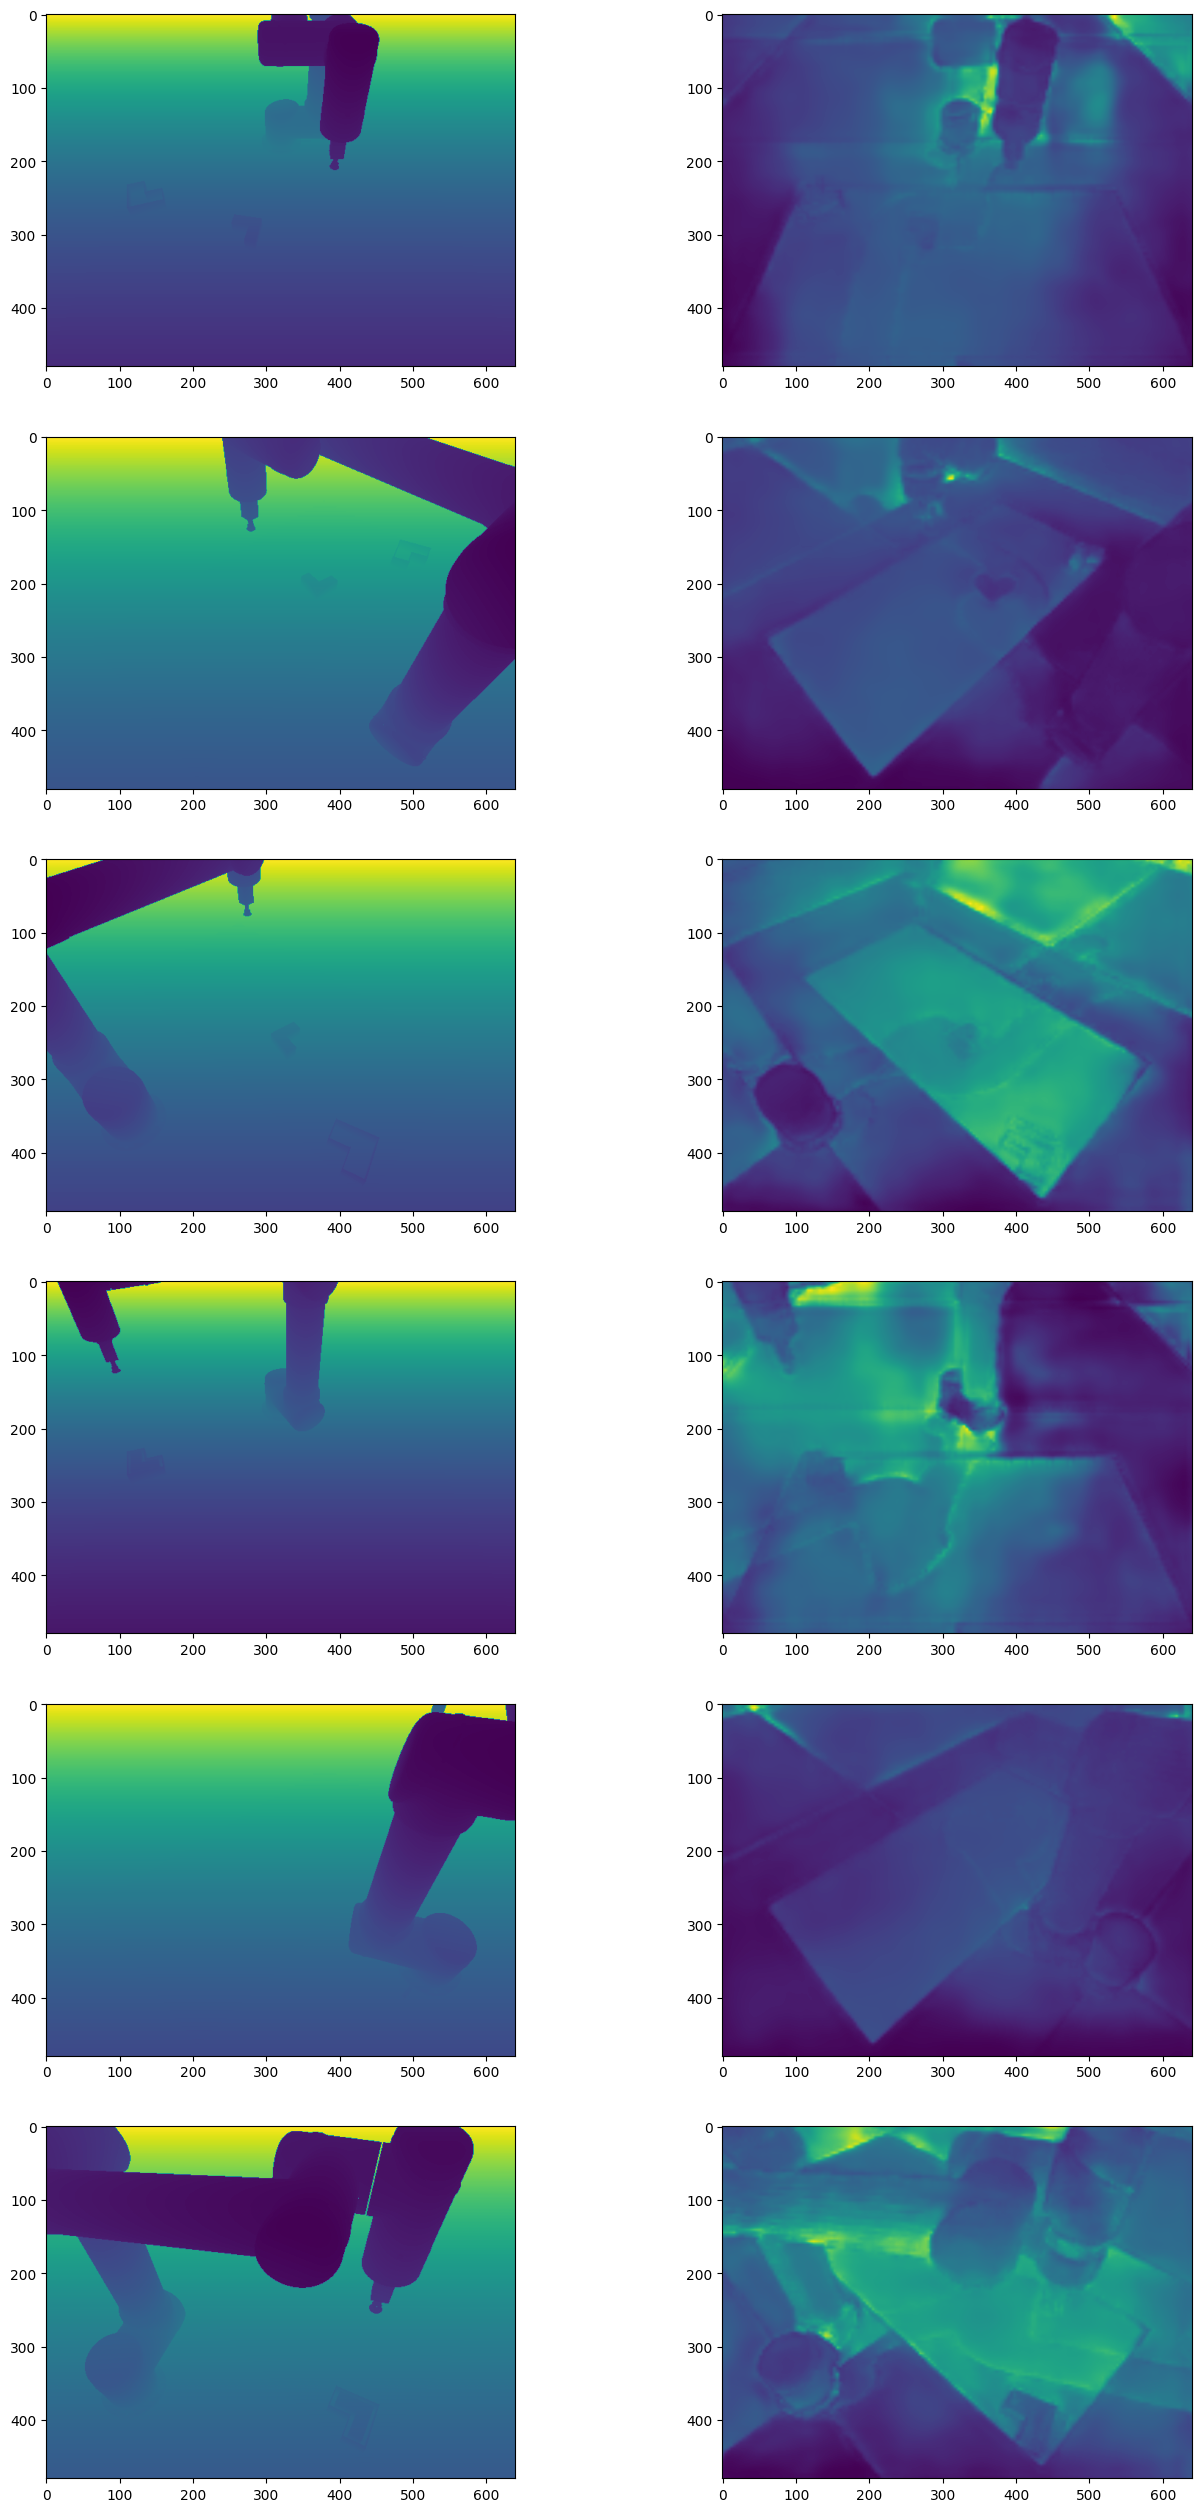

In [22]:
fig, axs = plt.subplots(6, 2, figsize=(16, 32))
counter = 0
for i in range(2):
    for j in range(3):
        axs[counter, 0].imshow(depth_images[i, j])
        axs[counter, 1].imshow(output_batch[i, j])
        counter += 1


In [3]:
cfg = mmcv.Config.fromfile(
    Path(
        "Monocular-Depth-Estimation-Toolbox/configs/adabins/adabins_efnetb5ap_kitti_24e.py"
    )
)
adabins = build_depther(cfg.model, test_cfg=cfg.get("test_cfg"))
checkpoint = load_checkpoint(
    adabins, str(Path("checkpoints/adabins_efnetb5_kitti.pth")), map_location="cpu"
)
adabins = adabins.to(device)
adabins.eval()


Using cache found in /home/matias/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


load checkpoint from local path: checkpoints/adabins_efnetb5_kitti.pth


DepthEncoderDecoder(
  (backbone): EfficientNet(
    (original_model): GenEfficientNet(
      (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (act1): SiLU(inplace=True)
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (act1): SiLU(inplace=True)
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (act1): SiLU(inplace=True)
              (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            )
            (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2

In [6]:
with torch.no_grad():
    output_batch = adabins.forward([preprocess(batch)], [img_metas], return_loss=False)
output_batch = np.concatenate(output_batch, axis=0).reshape(depth_images.shape)
output_batch_min = np.min(output_batch, axis=(2, 3))
output_batch_max = np.max(output_batch, axis=(2, 3))
output_batch = (
    255
    * (output_batch - output_batch_min[:, :, None, None])
    / (output_batch_max[:, :, None, None] - output_batch_min[:, :, None, None])
)


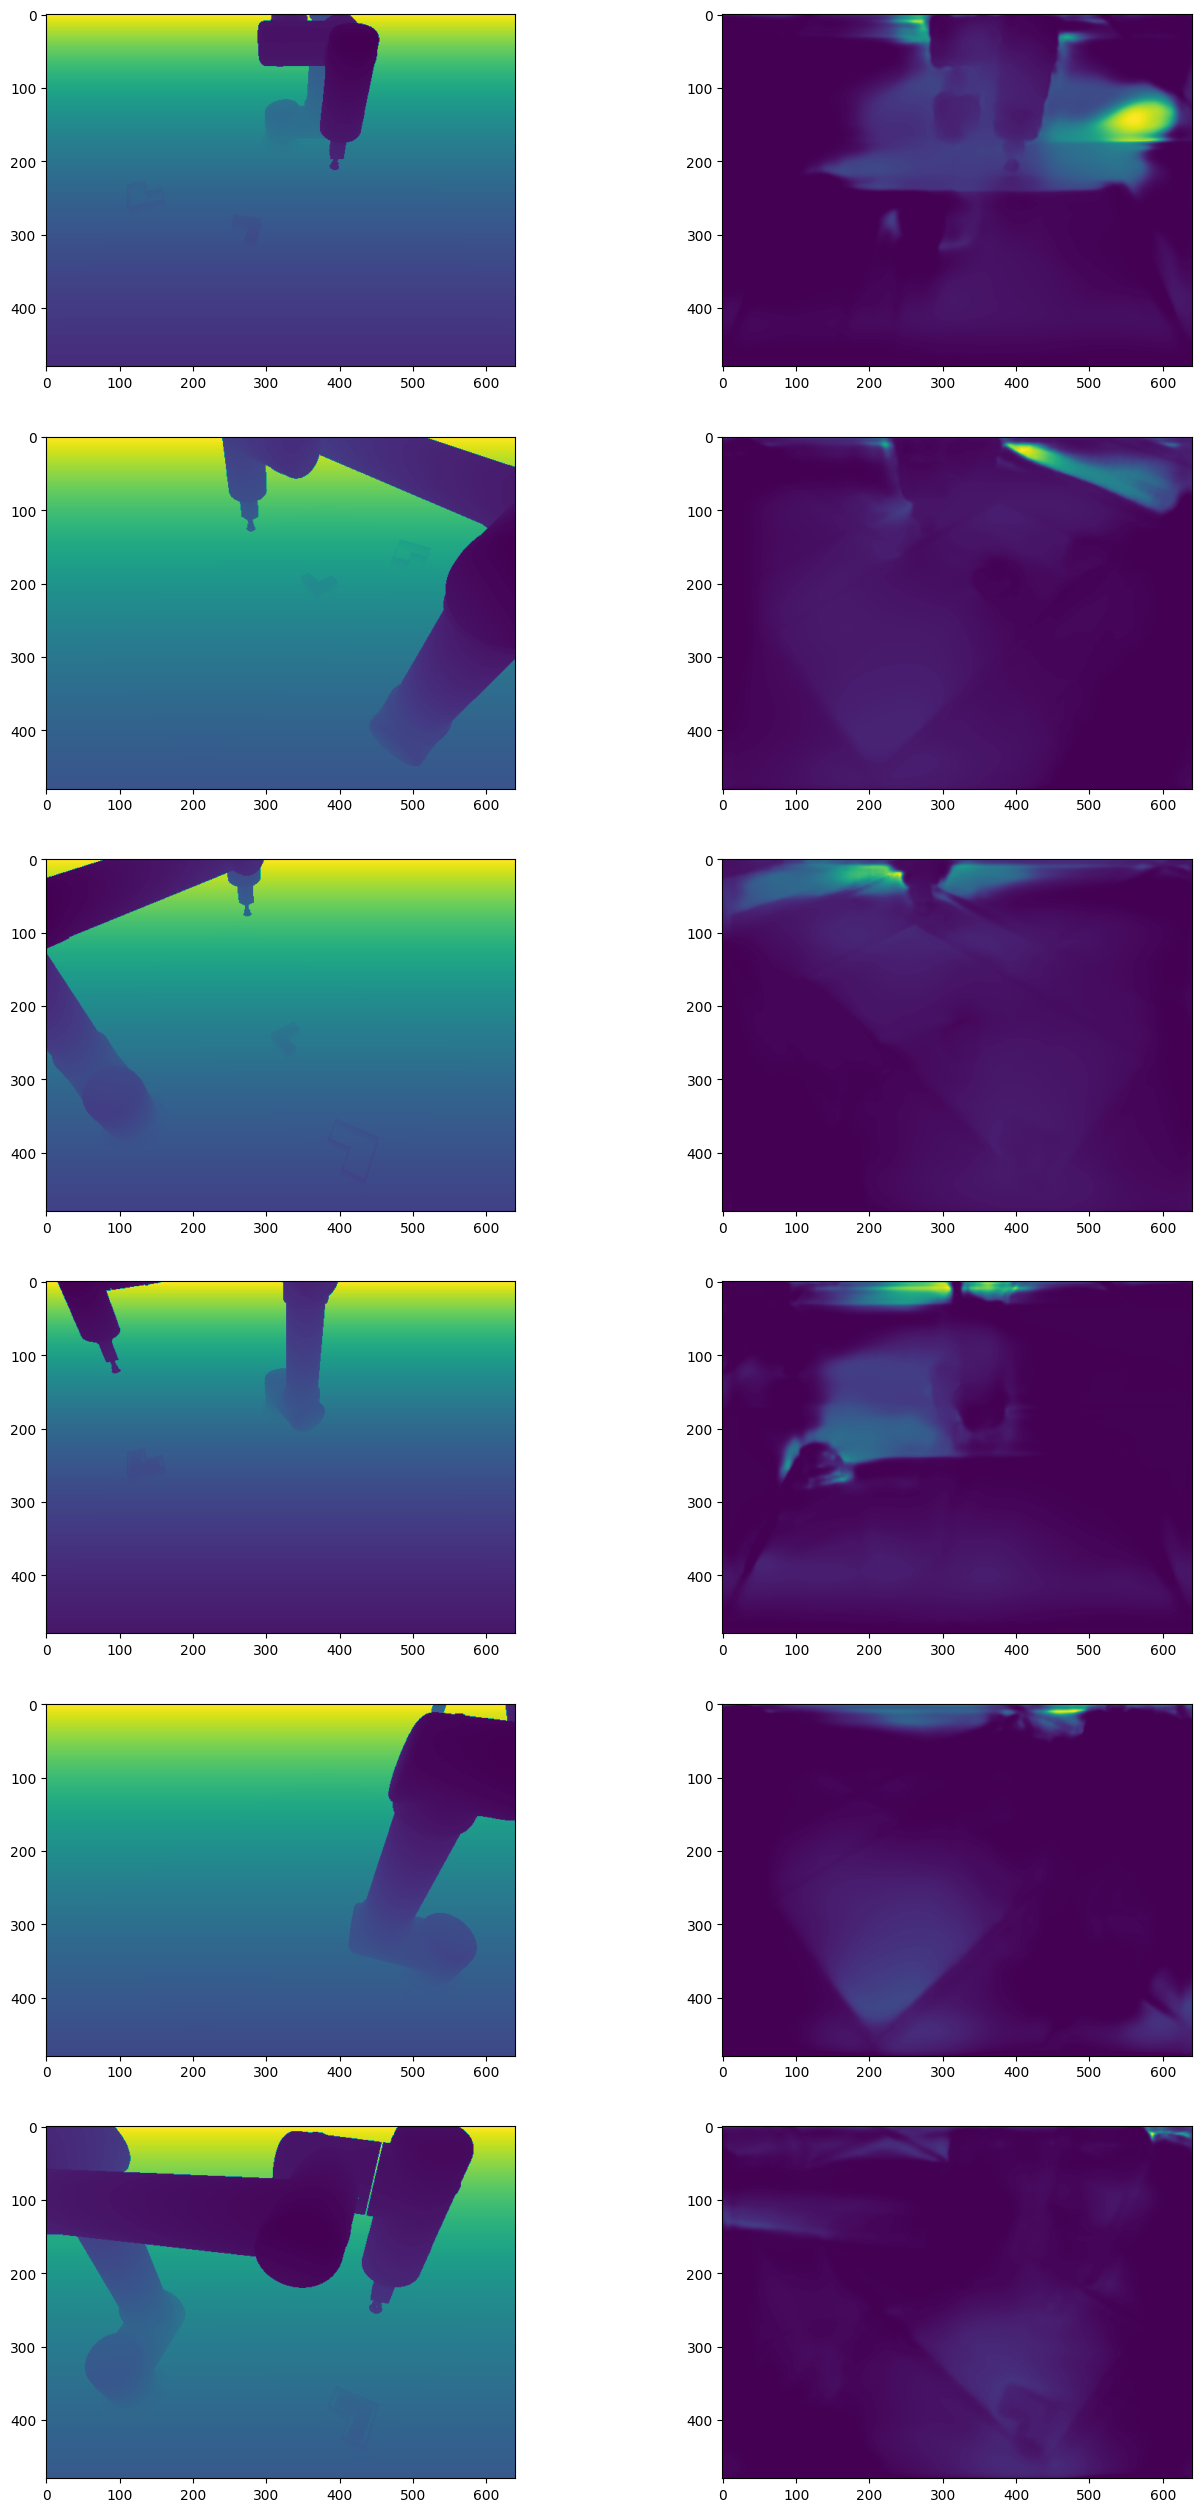

: 

In [7]:
fig, axs = plt.subplots(6, 2, figsize=(16, 32))
counter = 0
for i in range(2):
    for j in range(3):
        axs[counter, 0].imshow(depth_images[i, j])
        axs[counter, 1].imshow(output_batch[i, j])
        counter += 1
